## Das Quell-Panel Verfahren

Das Panel-Verfahren wurde Anfang der 1970er Jahre entwickelt und ist eine in der Industrie weiterhin weit verbreitete Methode zur Berechnung der Umströmung von Flügelprofilen und beliebiger anderer Körper. Durch ihren geringen Rechenaufwand kann die Panel-Methode sehr gut mit Optimierungsverfahren kombiniert werden. Meist dient sie dazu, eine erste Profilgeometrie mit den gewünschten Eigenschaften zu generieren, die dann im weiteren Verlauf durch genauere CFD-Berechnungen verfeinert wird.

Das Verfahren eignet sich sehr gut, um die Druckverteilung von beliebigen Körpern zu berechnen. In einer ersten Version des Verfahrens, dem Quell-Panel-Verfahren sind nur Berechnungen von Körpern ohne Auftrieb möglich. Das Wirbel-Panel-Verfahren bietet dann die Erweiterung zur Berechnung von Körpern mit Auftrieb.

Die Idee des Verfahrens besteht darin, die Körperkontur zunächst in diskrete "Paneele" aufzuteilen. Jedes der Paneele besteht aus einer unendlichen Anzahl von Quellen (oder Senken), die nebeneinander angeordnet sind und dafür sorgen, dass die Stromlinien tangential zum Paneel verlaufen.

![](Panelverfahren.pdf)

### Das Quell-Paneel

Wir müssen also zunächst herausfinden, wie die Geschwindigkeits-, Potential- und Stromfunktionen für ein Quell-Paneel lauten. Die Potentialfunktion einer einzelnen Quelle an der Stelle $(x_s,y_s)$ ist wie zuvor gezeigt:

$$\Phi = \frac{Q}{2\pi}\ln\sqrt{(x-x_s)^2+(y-y_s)^2}$$

Wenn wir nun die Größe $\lambda$ als Quellstärke pro Länge entlang des Paneels und pro Einheitstiefe definieren, wird die Potentialfunktion eines kleinen Ausschnitts $\text{d}s$ des Paneels zu:

$$\text{d}\Phi = \frac{\lambda}{2\pi}\ln\sqrt{(x-x(s))^2+(y-y(s))^2} \text{d}s$$


![](Paneel.pdf)

Das Potential des gesamten Paneels ergibt sich dann durch Integration über die Länge des Paneels zu:

$$\Phi(x,y) = \frac{\lambda}{2\pi}\int_a^b\ln\sqrt{(x-x(s))^2+(y-y(s))^2} \text{d}s$$

Ähnlich lassen sich auch die Stromfunktion und die Geschwindigkeitskomponenten bestimmen:

$$\Psi(x,y) = \frac{\lambda}{2\pi}\int_a^b\text{arctan}\frac{y-y(s)}{x-x(s)} \text{d}s$$

$$u(x,y) = \frac{\lambda}{2\pi}\int_a^b\frac{x-x(s)}{(x-x(s))^2+(y-y(s))^2} \text{d}s$$

$$v(x,y) = \frac{\lambda}{2\pi}\int_a^b\frac{y-y(s)}{(x-x(s))^2+(y-y(s))^2} \text{d}s$$



Für die Implementierung in Python ist es sinnvoll auf einen objektorientierten Ansatz zurückzugreifen und die Attribute und Funktionen, die wir für die Darstellung eines Panels benötigen in einer Klasse `Panel` zusammenzufassen.

In [1]:
import math
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
%matplotlib inline

class Panel:
    
    # Initialisiert ein Objekt der Klasse Panel
    def __init__(self, ax, ay, bx, by, lamb=0):
        # Panel-Stärke lambda
        self.lamb = lamb
        
        # Koordinaten der beiden Endpunkte des Panels als
        # Attribute des Objekts übernehmen
        self.ax = ax
        self.ay = ay
        self.bx = bx
        self.by = by
        
        # Koordinaten des Paneel-Mittelpunkts berechnen
        self.mx = 0.5*(ax+bx)
        self.my = 0.5*(ay+by)
        
        # Länge des Paneels berechnen
        self.laenge = math.sqrt((bx-ax)**2+(by-ay)**2)
        
        # Winkel zwischen x-Achse und Panel-Normalen
        if bx-ax <= 0:
            self.beta = math.acos((by-ay)/self.laenge)
        else:
            self.beta = math.pi + math.acos(-(by-ay)/self.laenge)
    
    def x(self, s):
        return self.ax + s*(self.bx-self.ax)/self.laenge  # Strahlensatz
    
    def y(self, s):
        return self.ay + s*(self.by-self.ay)/self.laenge  # Strahlensatz
    
    def phi(self, x,y):
        def integrand(s, x, y, xs, ys):
            return numpy.log(numpy.sqrt((x-xs(s))**2+(y-ys(s))**2))
        
        def integral(s_min, s_max, x, y, xs, ys):
            return integrate.quad(integrand, s_min, s_max, 
                         args=(x,y,self.x,self.y))[0]
        
        vec_integral = np.vectorize(integral)
        
        return (self.lamb / (2 * math.pi) 
                * vec_integral(0, self.laenge, x, y, self.x, self.y))
        
    def psi(self, x,y):
        def integrand(s, x, y, xs, ys):
            return numpy.arctan2(y-ys(s),x-xs(s))
        
        def integral(s_min, s_max, x, y, xs, ys):
            return integrate.quad(integrand, s_min, s_max, 
                         args=(x,y,self.x,self.y))[0]
        
        vec_integral = np.vectorize(integral)
        
        return (self.lamb / (2 * math.pi) 
                * vec_integral(0, self.laenge, x, y, self.x, self.y))        
        
    def vel(self, x,y):
        def integrand_u(s, x, y, xs, ys):
            return (x-xs(s))/((x-xs(s))**2+(y-ys(s))**2)
        def integrand_v(s, x, y, xs, ys):
            return (y-ys(s))/((x-xs(s))**2+(y-ys(s))**2)
        
        def integral_u(s_min, s_max, x, y, xs, ys):
            return integrate.quad(integrand_u, s_min, s_max, 
                         args=(x,y,self.x,self.y))[0]
        def integral_v(s_min, s_max, x, y, xs, ys):
            return integrate.quad(integrand_v, s_min, s_max, 
                         args=(x,y,self.x,self.y))[0]
        
        vec_integral_u = np.vectorize(integral_u)
        vec_integral_v = np.vectorize(integral_v)
        
        u = (self.lamb / (2 * math.pi) 
             * vec_integral_u(0, self.laenge, x, y, self.x, self.y))
        v = (self.lamb / (2 * math.pi) 
             * vec_integral_v(0, self.laenge, x, y, self.x, self.y))
        
        return u,v

Zeit, das Ganze mal grafisch darzustellen. Wir erzeugen zunächst ein Objekt der Klasse `Panel` mit dem Namen `panel1`, den Eckpunkten $a=(0,-2)$ und $b=(0,2)$ und einem Volumenstrom pro Länge und Tiefe von $2~\text{m}/{s}$.

Dann berechnen wir die Geschwindigkeitsverteilung an allen Punkten des Rechengitters und Plotten wie gewohnt die Stromlinien.

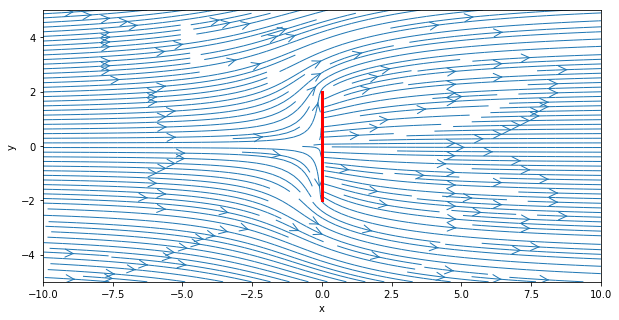

In [6]:
lamb = 1
panel1 = Panel(ax=0,ay=-2,bx=0,by=2,lamb=lamb)    # erzeuge neues Panel

nx = 400                              # Anzahl der Punkte in x-Richtung
ny = 200                              # Anzahl der Punkte in y-Richtung
x = np.linspace(-10, 10, nx, dtype=float)  # 1D-Array mit x-Koordinaten
y = np.linspace(-5,  5, ny, dtype=float)   # 1D-Array mit y-Koordinaten

X, Y = np.meshgrid(x, y )      # erzeugt das Gitter mit nx * ny Punkten

u,v = panel1.vel(X, Y)
u += 0.5

# Neuen Plot einrichten
plt.figure(figsize=(10, 5))
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-10,10)
plt.ylim(-5,5)

# Stromlinien mit Matplotlib-Funktion darstellen
plt.streamplot(X, Y, u, v, 
                  density=2, linewidth=1, arrowsize=2, arrowstyle='->')
plt.plot([panel1.ax, panel1.bx],[panel1.ay, panel1.by], 
         color='red', linewidth=3);

Unser Quell-Paneel macht schon (fast) was es soll. Es hat nur noch einen Schönheitsfehler: aus dem Paneel scheint entgegen der Strömungsrichtung ein Volumenstrom auszutreten. Wir möchten aber, dass das Paneel zur Anströmrichtung hin eine undurchlässige Wand simuliert. Die stromabgewandte Seite wird später auf der Innenseite des umströmten Körpers liegen, so dass die dort austretende Strömung keine Bedeutung hat).

Wir müssen die Stärke $\lambda$ also genau so wählen, dass der Staupunkt gerade auf dem Paneel zum liegen kommt. Da der pro Länge und Einheitstiefe austretende Volumenstrom ohne überlagerte Translationsströmung zu beiden Seiten des Quell-Panels gleich ist, tritt auf der der Strömung zugewandten Seite genau $\lambda/2$ aus. Damit der Staupunkt also auf dem Quell-Paneel liegt, muss dieser auf die Länge und Einheitstiefe bezogene Volumenstrom also gerade durch die Translationsströmung kompensiert werden:

$$\frac{\lambda}{2} = u_\infty$$

Wenn wir oben im Python-Code `lamb = 1` setzen, sollten wir also das gewünschte Ergebnis bekommen. 

### Überlagerung mehrerer Paneele zur Beschreibung eines umströmten Körpers

Zur Abbildung des umströmten Körpers mit Paneelen, müssen wir sicherstellen, dass die Geschwindigkeit am Ort der Paneele genau tangential verläuft. Anders ausgedrückt, muss die Geschwindigkeitskomponente normal zum Paneel $u_n$ gleich Null sein. Der Einfachheit halber fordern wir, dass $u_n$ nur im Mittelpunkt des Paneels Null sein muss.

Da die Normalenkomponente der Geschwindigkeit gerade die Ableitung der Potentialfunktion nach der Normalenrichtung ist, gilt:

$$u_n(x_m,y_m) = \frac{\partial \phi}{\partial n}\left(x_m, y_m\right) \stackrel{!}{=} 0$$

**Und jetzt wird's etwas komplizierter. Denn die Potentialfunktion $\phi$ in dieser Gleichung ist nicht einfach die eines einzelnen Paneels, sondern die aller $N$ linear überlagerter Paneele und der überlagerten Translationsströmung:**

$$\phi(x,y) = u_\infty x + v_\infty y + \sum_{i=1}^N \frac{\lambda_i}{2\pi}\int\limits_a^b\ln\sqrt{(x-x_i(s_i))^2+(y-y_i(s_i))^2} \text{d}s_i$$

Die Ableitung von $\phi$ an der Stelle $(x_m, y_m)$ nach der Normalenrichtung ist dann für das Paneel $j$:

$$\frac{\partial \phi(x_{m_j},y_{m_j})}{\partial n_j} = u_\infty\frac{\partial x_{m_j}}{\partial n_j} + v_\infty\frac{\partial y_{m_j}}{\partial n_j} + \frac{\lambda_j}{2}$$
$$+ \sum_{i\ne j}^N \frac{\lambda_i}{2\pi}\int\limits_{a_i}^{b_i} 
\frac{\left(x_{m_j}-x_i(s_i)\right)\frac{\partial x_{m_j}}{\partial n_j} 
+ \left(y_{m_j}-y_i(s_i)\right)\frac{\partial y_{m_j}}{\partial n_j}}
{\left(x_{m_j}-x_i(s_i)\right)^2+\left(y_{m_j}-y_i(s_i)\right)^2} \text{d}s_i $$

wobei der Beitrag des $j$-ten Paneels zu sich selbst mit $\lambda/2$ gesondert betrachtet wird (vgl. oben) und die partiellen Ableitungen nach der Normalenrichtung mit dem Winkel $\beta$ zwischen $x$-Achse und Normale (vgl. Bild des Paneels oben) 

$$\frac{\partial x_{m_j}}{\partial n_j} = \cos \beta_j \qquad \text{und} \qquad \frac{\partial y_{m_j}}{\partial n_j} = \sin \beta_j$$

ergeben.

Wir haben jetzt für jedes der $N$ Paneele eine Gleichung für die Randbedingung. Damit suchen wir $N$ Werte für die jeweilige Stärke $\lambda_i$ des Paneels. Es geht nun also nur noch darum, ein System mit $N$ linearen algebraischen Gleichungen zu lösen, ähnlich wie wir das schon bei der Finite-Differenzen-Methode kennengelernt haben.

$$
A_{ij}\cdot
    \begin{pmatrix}
    \lambda_1 \\
    \lambda_2 \\
    \vdots \\
    \lambda_N
    \end{pmatrix}
=
    \begin{pmatrix}
    -u_\infty \cos \beta_1 - v_\infty \sin \beta_1 \\
    -u_\infty \cos \beta_2 - v_\infty \sin \beta_2 \\
    \vdots \vphantom{\ddots} \\
    -u_\infty \cos \beta_N - v_\infty \sin \beta_N
    \end{pmatrix}
$$ 

mit der Koeffizientenmatrix

$$A_{ij} = 
\begin{cases}
     \frac{1}{2} & \text{für } i = j \\
     \frac{1}{2\pi}\displaystyle\int\limits_{a_i}^{b_i} \frac{\left(x_{m_j}-x_i(s_i)\right)\cos \beta_j + \left(y_{m_j}-y_i(s_i)\right)\sin \beta_j}{\left(x_{m_j}-x_i(s_i)\right)^2+\left(y_{m_j}-y_i(s_i)\right)^2} \text{d}s_i & \text{für } i \ne j
\end{cases}$$

### Beispiel

In einem Beispiel soll die Umströmung des ganz oben gezeigten Ovals simuliert werden. Die Anströmgeschwindigkeit sei $u_\infty = 1~\text{m}/{s}$. Wir approximieren das Oval mit 4 Paneele, welche die folgenden Eckpunkte haben:

Paneel 1: ( 0.0, 0.0) -> ( 1.0, 0.5)
Paneel 2: ( 1.0, 0.5) -> ( 2.0, 0.0)
Paneel 3: ( 2.0, 0.0) -> ( 1.0,-0.5)
Paneel 4: ( 1.0,-0.5) -> ( 0.0, 0.0)

Bevor wir das zu lösende Gleichungssystem aufstellen können, müssen wir noch eine Funktion für das Integral in der Koeefizientenmatrix programmieren. Wir tun dies analog zur Vorgehensweise in der Klasse `Panel`:

In [7]:
def norm_int(panel_i, panel_j):
    # Berechnet das Integral in der Koeffizientenmatrix
    
    def integrand(s):
        delta_x = panel_j.mx - panel_i.x(s)
        delta_y = panel_j.my - panel_i.y(s)
        return ((delta_x*math.cos(panel_j.beta) 
                + delta_y*math.sin(panel_j.beta))
                / (delta_x*delta_x + delta_y*delta_y))
    
    return integrate.quad(integrand, 0.0, panel_i.laenge)[0]

Als nächstes erzeugen wir die 4 Paneele:

In [8]:
panels = []    # Liste der Paneele
#panels.append(Panel(ax=-5.0,ay= 0.0, bx= 0.0, by= 2.0))
#panels.append(Panel(ax= 0.0,ay= 2.0, bx= 5.0, by= 0.0))
#panels.append(Panel(ax= 5.0,ay= 0.0, bx= 0.0, by=-2.0))
#panels.append(Panel(ax= 0.0,ay=-2.0, bx=-5.0, by= 0.0))
panels.append(Panel(bx=-5.0,by= 0.0, ax= 0.0, ay= 2.0))
panels.append(Panel(bx= 0.0,by= 2.0, ax= 5.0, ay= 0.0))
panels.append(Panel(bx= 5.0,by= 0.0, ax= 0.0, ay=-2.0))
panels.append(Panel(bx= 0.0,by=-2.0, ax=-5.0, ay= 0.0))
N = len(panels)

und stellen dann das Gleichungssytem auf:

In [9]:
u_oo = 1.0
v_oo = 0.0

# die Koeffizientenmatrix A_ij
A_ij = np.zeros((N,N), dtype=float)

for i, panel_i in enumerate(panels):
    for j, panel_j in enumerate(panels):
        if i == j:
            A_ij[i,j] = 0.5
        else:
            A_ij[i,j] = norm_int(panel_i, panel_j) / (2 * math.pi)
            
# und die rechte Seite des Gleichungssystems
b_i = np.zeros(N, dtype=float)

for i, panel_i in enumerate(panels):
    b_i[i] = -u_oo * math.cos(panel_i.beta) - v_oo * math.sin(panel_i.beta)

Zur Lösung des Gleichungssystems nutzen wir einen in Python (bzw. Numpy) vorhandenen Löser:

In [10]:
lambda_i = np.linalg.solve(A_ij, b_i)

for i, panel_i in enumerate(panels):
    panel_i.lamb = lambda_i[i]

Nachdem jetzt allen Paneelen die richtige Stärke $\lambda_i$ zugewiesen wurde, können wir das Geschwindigkeitsfeld berechnen:

In [11]:
# Anteil der Translationsströmung:
u = np.full_like(X, u_oo)
v = np.full_like(Y, v_oo)

# Anteil der einzelnen Paneele
for i, panel_i in enumerate(panels):
    u_i,v_i = panel_i.vel(X, Y)
    u += u_i
    v += v_i

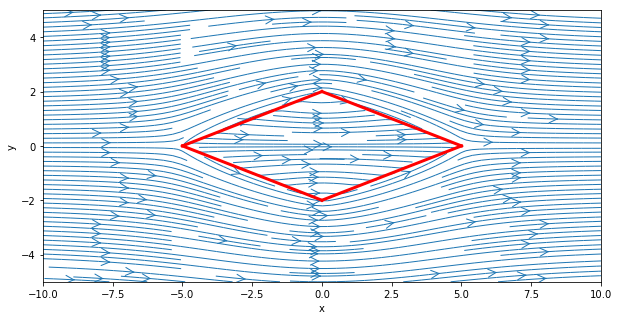

In [12]:
# Neuen Plot einrichten
plt.figure(figsize=(10, 5))
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-10,10)
plt.ylim(-5,5)

# Stromlinien mit Matplotlib-Funktion darstellen
plt.streamplot(X, Y, u, v, 
                  density=2, linewidth=1, arrowsize=2, arrowstyle='->');

for i, panel_i in enumerate(panels):
    plt.plot([panel_i.ax, panel_i.bx],[panel_i.ay, panel_i.by], 
             color='red', linewidth=3);

Mit dem Quell-Panel-Verfahren können wir die Druckverteilung auf beliebigen umströmten Körpern berechnen, solange die Strömung stationär und reibungsfrei ist und der Körper keinen Auftrieb erfährt.

Um auch Umströmungen mit Auftrieb beschreiben zu können, muss das Verfahren noch erweitert werden. Wie wir bei der Zylinderumströmung gesehen haben, kann der Auftrieb mit der Potentialtheorie nur durch eine Überlagerung von Potentialwirbeln simuliert werden. Die Vorgehensweise ist ganz ähnlich der bisherigen, nur dass jedem Paneel noch ein Potentialwirbel überlagert wird. 

Im Rahmen der Vorlesung im WS17 werden wir die Erweiterung nicht mehr behandeln. Eine gute Beschreibung der vollständigen Verfahren findet sich z.B. [hier](http://homepages.hs-bremen.de/~kortenfr/Aerodynamik/script/node31.html).


---
###### Copyright (c) 2017, Florian Theobald und Matthias Stripf

Der folgende Python-Code darf ignoriert werden. Er dient nur dazu, die richtige Formatvorlage für die Jupyter-Notebooks zu laden.

In [9]:
from IPython.core.display import HTML
def css_styling():
    styles = open('TFDStyle.css', 'r').read()
    return HTML(styles)
css_styling()